# Analyse de la productivité des développeurs

Ce notebook analyse les facteurs influençant la réussite des tâches chez les développeurs.

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

## 1. Chargement des données

In [69]:
df = pd.read_csv('Developer_Productivity_Synthetic_Syncora.csv')
print(f"Dataset: {df.shape[0]} lignes, {df.shape[1]} colonnes")
df.head(10)

Dataset: 2000 lignes, 9 colonnes


,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success
0,5.190476,575,6,7.467749,6,1,0.729743,3.666136,1
1,3.069862,320,1,6.483703,0,2,0.086857,3.449533,0
2,5.052262,532,3,9.687784,9,1,0.514440,1.509259,1
3,3.694441,359,4,8.150044,3,0,1.226923,4.099178,0
4,6.883442,601,4,8.902919,5,0,0.661380,3.784728,1
5,5.331725,497,4,7.608980,3,2,0.892341,4.272347,1
6,2.772506,287,3,9.488929,5,0,0.598634,3.260076,0
7,2.249032,213,2,7.997302,1,0,0.674848,3.565879,0
8,5.432846,540,6,7.323271,6,1,0.754723,3.792893,1
9,2.135195,164,1,9.573187,2,0,1.254352,3.266822,0


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hours_coding      2000 non-null   float64
 1   coffee_intake_mg  2000 non-null   int64  
 2   distractions      2000 non-null   int64  
 3   sleep_hours       2000 non-null   float64
 4   commits           2000 non-null   int64  
 5   bugs_reported     2000 non-null   int64  
 6   ai_usage_hours    2000 non-null   float64
 7   cognitive_load    2000 non-null   float64
 8   task_success      2000 non-null   int64  
dtypes: float64(4), int64(5)
memory usage: 140.8 KB


In [71]:
df.describe()

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success
count,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,5.006187,461.120000,2.96000,6.960147,4.700000,0.816000,1.512217,4.525198,0.618000
std,1.966547,144.722558,1.66847,1.476519,2.657354,1.065228,1.091252,1.908709,0.485998
min,-0.208322,27.000000,0.00000,2.750789,0.000000,0.000000,-0.051374,0.774451,0.000000
25%,3.690653,374.000000,2.00000,6.029423,3.000000,0.000000,0.674650,3.243968,0.000000
50%,5.031464,500.000000,3.00000,6.989199,5.000000,0.000000,1.266210,4.444180,1.000000
75%,6.323190,590.000000,4.00000,7.993181,6.000000,1.000000,2.114931,5.867945,1.000000
max,12.269495,636.000000,8.00000,10.210599,13.000000,5.000000,6.409517,10.203222,1.000000


In [72]:
# Valeurs manquantes
print("Valeurs manquantes par colonne:")
print(df.isnull().sum())

Valeurs manquantes par colonne:
hours_coding        0
coffee_intake_mg    0
distractions        0
sleep_hours         0
commits             0
bugs_reported       0
ai_usage_hours      0
cognitive_load      0
task_success        0
dtype: int64


In [73]:
# Doublons
print(f"Nombre de doublons: {df.duplicated().sum()}")

Nombre de doublons: 0


La dataset est très propre. 8 colonnes numériques, 1 colonne label (boolean). Aucune valeur manquante.

## 2. Analyse exploratoire

### 2.1 Variable cible

Distribution de task_success:
task_success
1    1236
0     764
Name: count, dtype: int64

Proportion: 61.8% de succès


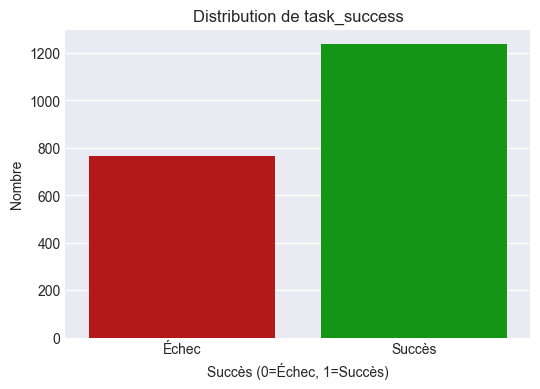

In [74]:
# Distribution de la variable cible
target_counts = df['task_success'].value_counts()
print("Distribution de task_success:")
print(target_counts)
print(f"\nProportion: {target_counts[1]/len(df)*100:.1f}% de succès")

plt.figure(figsize=(6, 4))
colors = ['#cc0000', '#00aa00']  # Rouge=Échec, Vert=Succès
sns.countplot(data=df, x='task_success', palette=colors)
plt.title('Distribution de task_success')
plt.xlabel('Succès (0=Échec, 1=Succès)')
plt.ylabel('Nombre')
plt.xticks([0, 1], ['Échec', 'Succès'])
plt.show()

### 2.2 Distribution des variables

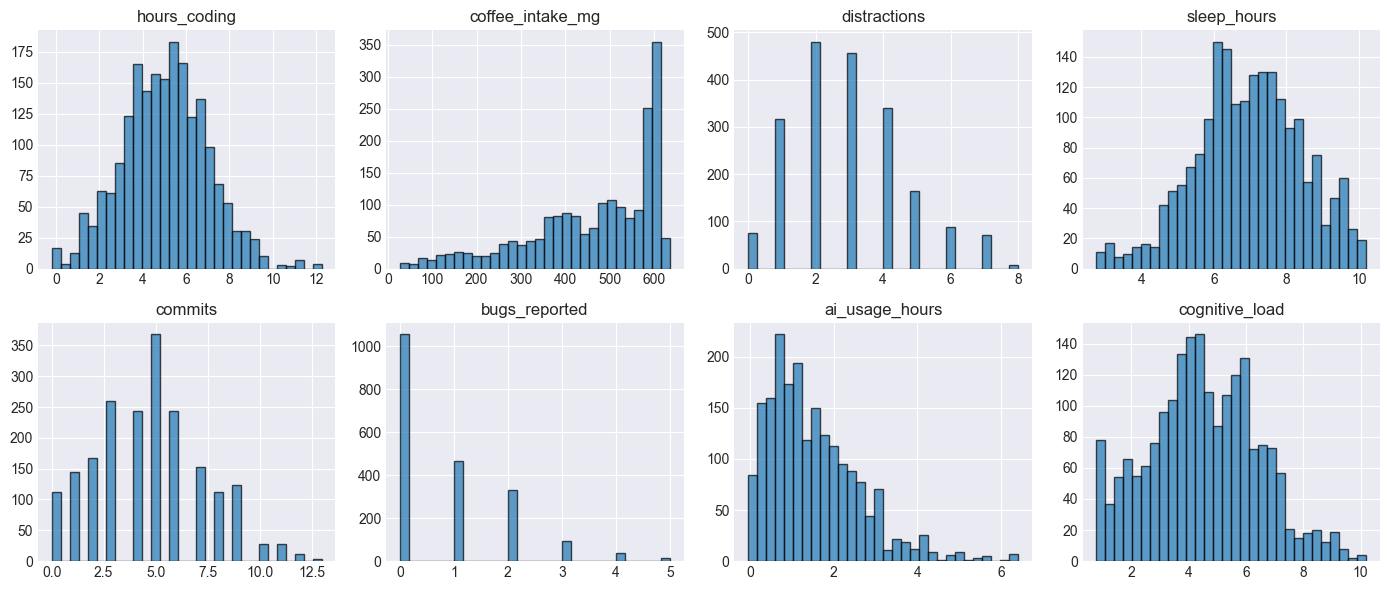

In [75]:
# Histogrammes
features = ['hours_coding', 'coffee_intake_mg', 'distractions', 'sleep_hours', 
            'commits', 'bugs_reported', 'ai_usage_hours', 'cognitive_load']

fig, axes = plt.subplots(2, 4, figsize=(14, 6))
axes = axes.flatten()

for i, col in enumerate(features):
    axes[i].hist(df[col], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

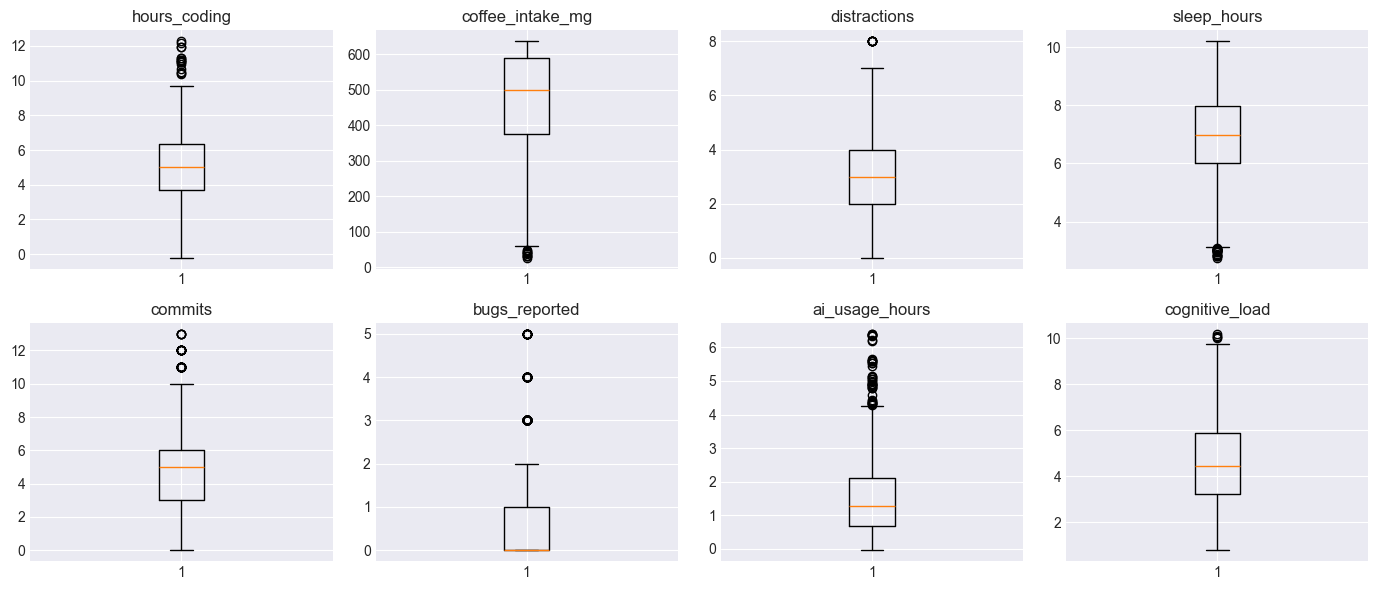

In [76]:
# Boxplots pour détecter les outliers
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
axes = axes.flatten()

for i, col in enumerate(features):
    axes[i].boxplot(df[col])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

### 2.3 Corrélations

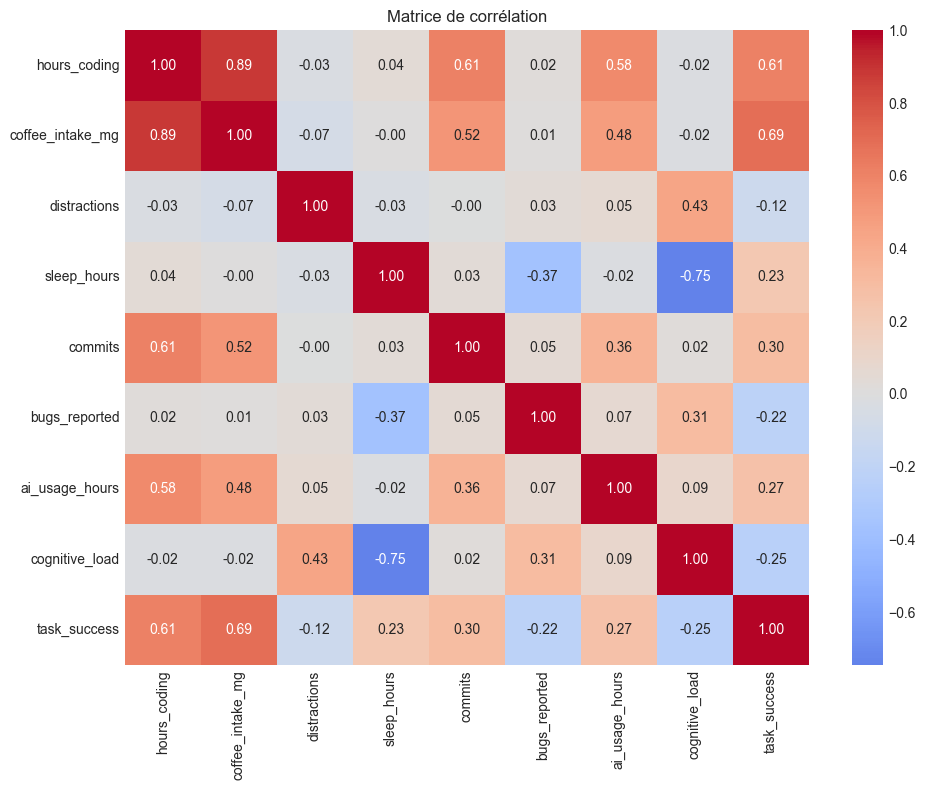

In [77]:
# Matrice de corrélation
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matrice de corrélation')
plt.tight_layout()
plt.show()

In [78]:
# Corrélations avec la cible
print("Corrélations avec task_success:")
correlations = df.corr()['task_success'].drop('task_success').sort_values(key=abs, ascending=False)
print(correlations)

Corrélations avec task_success:
coffee_intake_mg    0.691444
hours_coding        0.613449
commits             0.303217
ai_usage_hours      0.266474
cognitive_load     -0.246958
sleep_hours         0.227026
bugs_reported      -0.217007
distractions       -0.124965
Name: task_success, dtype: float64


### 2.4 Analyse par groupe

In [79]:
# Comparaison des moyennes selon le succès
print("Moyenne des variables selon task_success:")
print(df.groupby('task_success')[features].mean().T)

Moyenne des variables selon task_success:
task_success               0           1
hours_coding        3.472146    5.954414
coffee_intake_mg  333.873037  539.774272
distractions        3.225131    2.796117
sleep_hours         6.533893    7.223624
commits             3.675393    5.333333
bugs_reported       1.109948    0.634304
ai_usage_hours      1.142445    1.740781
cognitive_load      5.124598    4.154695


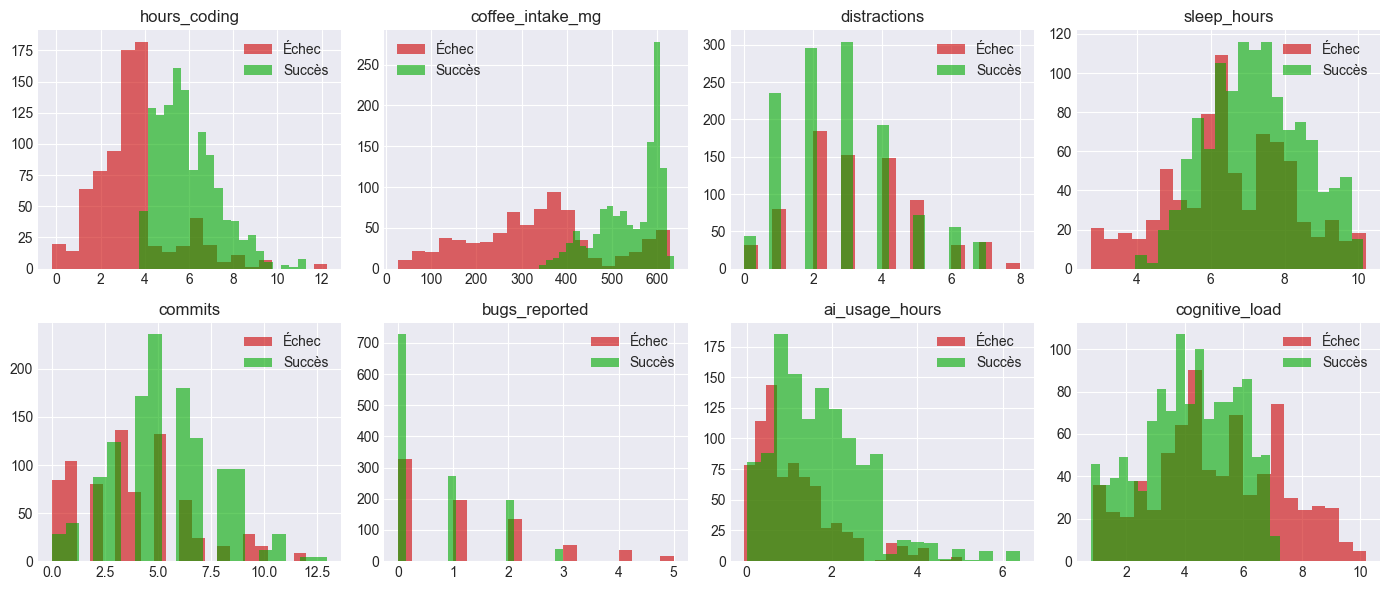

In [80]:
# Visualisation par histogrammes superposés (harmonisé rouge=échec, vert=succès)
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
axes = axes.flatten()

for i, col in enumerate(features):
    axes[i].hist(df[df['task_success']==0][col], bins=20, alpha=0.6, label='Échec', color='#cc0000')
    axes[i].hist(df[df['task_success']==1][col], bins=20, alpha=0.6, label='Succès', color='#00aa00')
    axes[i].set_title(col)
    axes[i].legend()

plt.tight_layout()
plt.show()

## 3. Preprocessing

In [81]:
# Séparation features / target
X = df[features]
y = df['task_success']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (2000, 8)
y shape: (2000,)


In [82]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")

Train: 1600 samples
Test: 400 samples


In [83]:
# Encodage des données numériques - Un simple StandardScaler suffit ici 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Données encodées")

Données encodées


## 4. Modélisation

In [84]:
# Configuration de la cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dictionnaire pour stocker les résultats
results = {}

### 4.1 Régression Logistique

Première approche avec une régression logistique qui est un modèle adapté à une classification binaire.

In [85]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print(f"Meilleurs paramètres: {grid.best_params_}")
print(f"Score CV: {grid.best_score_:.4f}")

results['Régression logistique'] = grid.best_estimator_

Meilleurs paramètres: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Score CV: 0.9137


### 4.2 Decision Tree

2nde approche avec un arbre de décision car certains paramètres, comme le nombre d'heures, semblent avoir une grande influence sur le succès d'une tâche.

In [86]:
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print(f"Meilleurs paramètres: {grid.best_params_}")
print(f"Score CV: {grid.best_score_:.4f}")

results['Arbre de décision'] = grid.best_estimator_

Meilleurs paramètres: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Score CV: 0.9802


### 4.3 Random Forest

3ème approche avec Random Forest pour voir si on arrive à obtenir de meilleurs résultats.

In [87]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print(f"Meilleurs paramètres: {grid.best_params_}")
print(f"Score CV: {grid.best_score_:.4f}")

results['Random Forest'] = grid.best_estimator_

Meilleurs paramètres: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}
Score CV: 0.9893


### 4.4 SVM

Approche géométrique qui cherche l'hyperplan séparant au mieux les classes avec une marge maximale.

In [88]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print(f"Meilleurs paramètres: {grid.best_params_}")
print(f"Score CV: {grid.best_score_:.4f}")

results['SVM'] = grid.best_estimator_

Meilleurs paramètres: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Score CV: 0.9944


### 4.5 KNN

Approche différentes en recherchant les K plus proches voisins

In [89]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print(f"Meilleurs paramètres: {grid.best_params_}")
print(f"Score CV: {grid.best_score_:.4f}")

results['KNN'] = grid.best_estimator_

Meilleurs paramètres: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Score CV: 1.0000


## 5. Évaluation des modèles

In [90]:
# Évaluation sur le jeu de test
metrics_df = []

for name, model in results.items():
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    metrics_df.append({
        'Modèle': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    })

metrics_df = pd.DataFrame(metrics_df)
metrics_df = metrics_df.sort_values('F1', ascending=False)
print(metrics_df.to_string(index=False))

               Modèle  Accuracy  Precision   Recall       F1  ROC-AUC
                  KNN    1.0000   1.000000 1.000000 1.000000 1.000000
                  SVM    0.9925   0.988000 1.000000 0.993964 0.999894
        Random Forest    0.9900   0.987952 0.995951 0.991935 0.999497
    Arbre de décision    0.9725   0.979675 0.975709 0.977688 0.970006
Régression logistique    0.9000   0.896552 0.947368 0.921260 0.966235


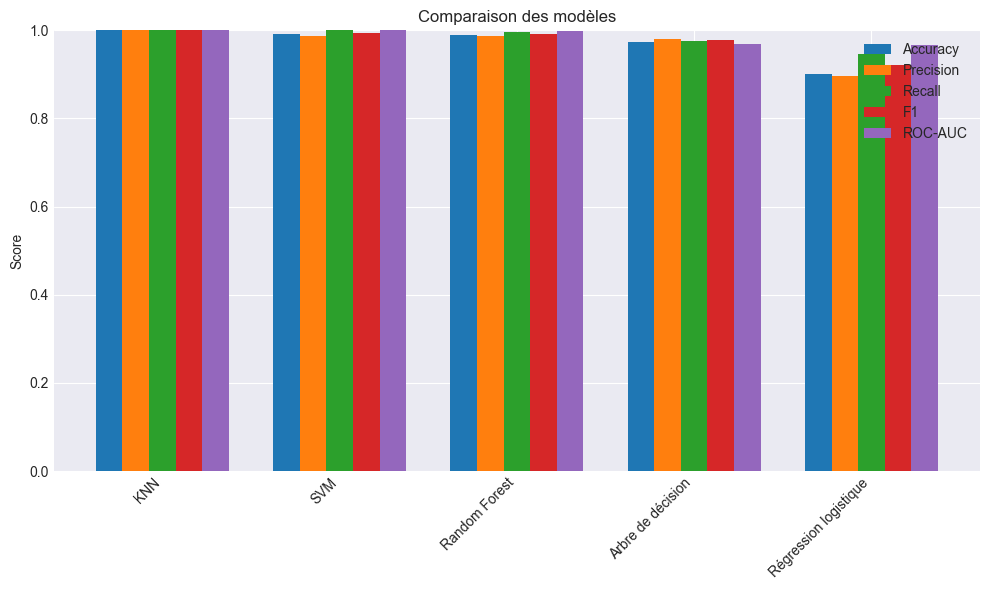

In [91]:
# Visualisation des métriques
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(metrics_df))
width = 0.15

for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']):
    ax.bar(x + i*width, metrics_df[metric], width, label=metric)

ax.set_ylabel('Score')
ax.set_title('Comparaison des modèles')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(metrics_df['Modèle'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

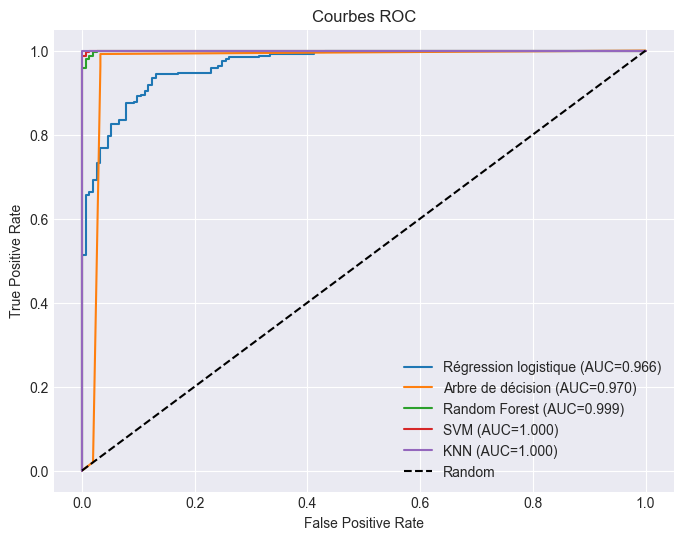

In [92]:
# Courbes ROC
plt.figure(figsize=(8, 6))

for name, model in results.items():
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbes ROC')
plt.legend(loc='lower right')
plt.show()

Meilleur modèle: KNN

Rapport de classification:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       247

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



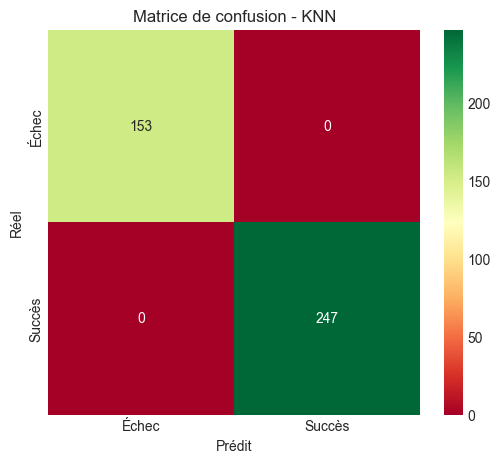

In [93]:
# Matrice de confusion du meilleur modèle
best_model_name = metrics_df.iloc[0]['Modèle']
best_model = results[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)

print(f"Meilleur modèle: {best_model_name}")
print("\nRapport de classification:")
print(classification_report(y_test, y_pred_best))

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', 
            xticklabels=['Échec', 'Succès'], yticklabels=['Échec', 'Succès'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title(f'Matrice de confusion - {best_model_name}')
plt.show()

## 6. Feature Importance

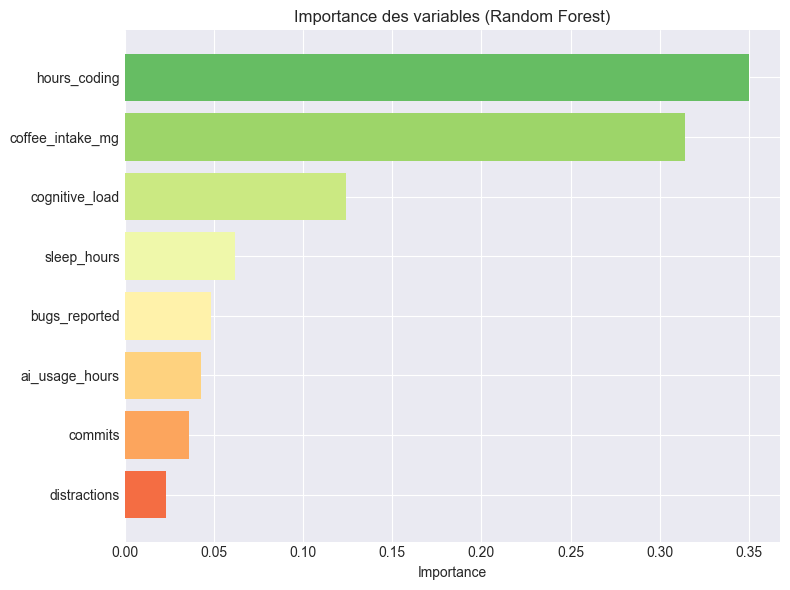

In [94]:
# Importance des features (Random Forest)
rf_model = results['Random Forest']
importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(8, 6))
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(importance)))
plt.barh(importance['Feature'], importance['Importance'], color=colors)
plt.xlabel('Importance')
plt.title('Importance des variables (Random Forest)')
plt.tight_layout()
plt.show()

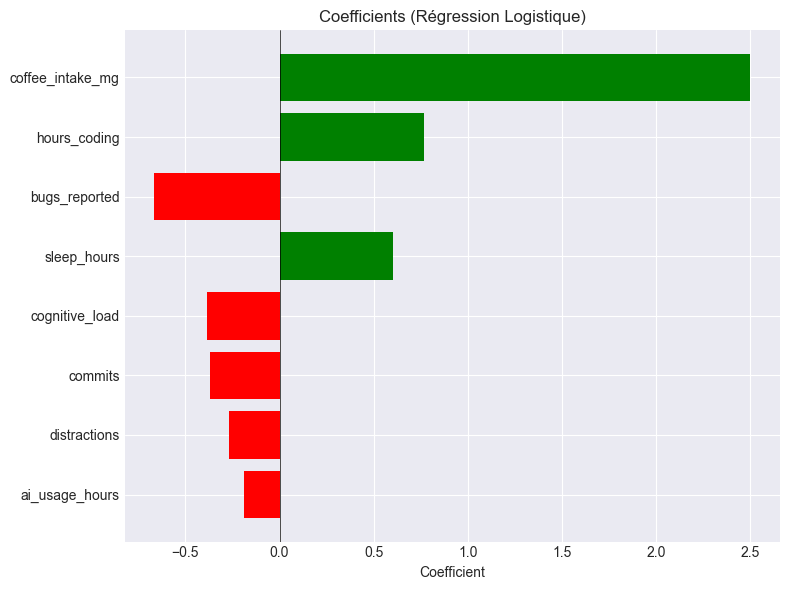

In [96]:
# Coefficients de la régression logistique
lr_model = results['Régression logistique']
coefs = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=True)

plt.figure(figsize=(8, 6))
colors = ['green' if c > 0 else 'red' for c in coefs['Coefficient']]
plt.barh(coefs['Feature'], coefs['Coefficient'], color=colors)
plt.xlabel('Coefficient')
plt.title('Coefficients (Régression Logistique)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

## 7. Visualisation des modèles

### 7.1 Arbre de décision

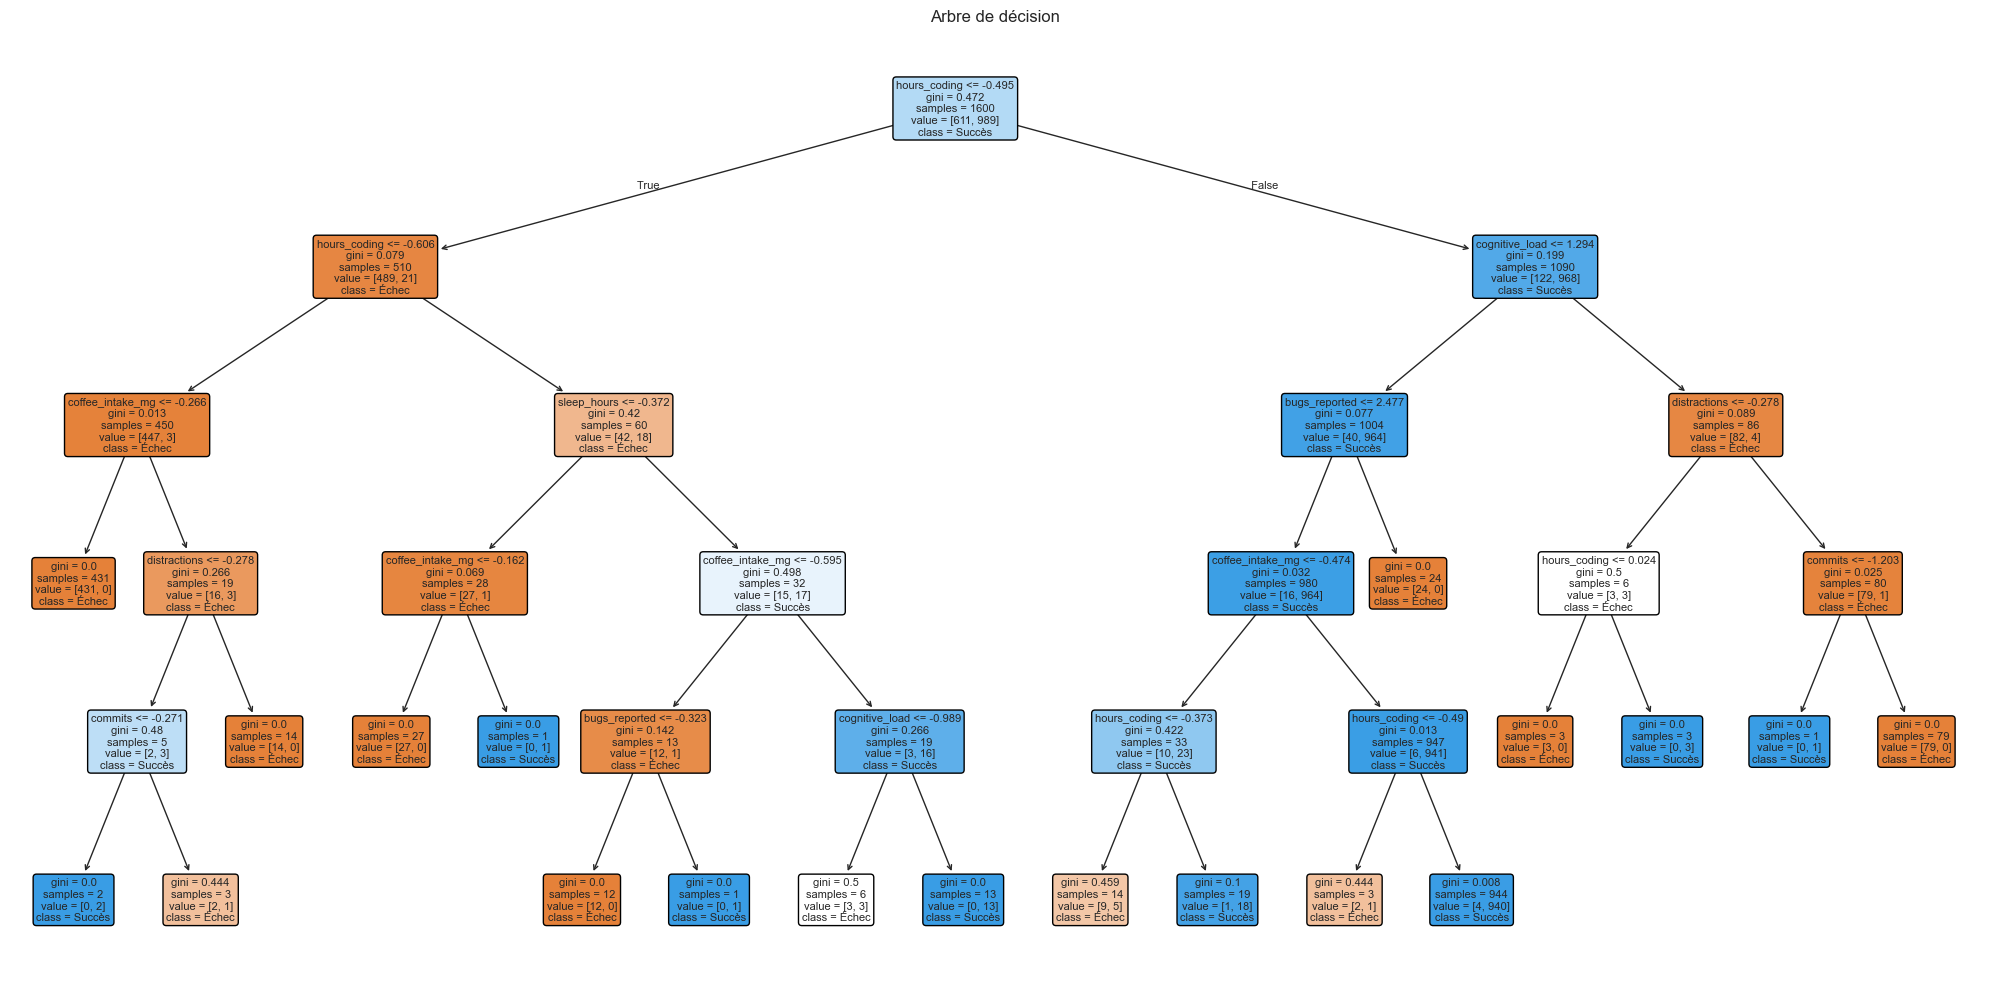

Profondeur totale de l'arbre: 5
Nombre de feuilles: 19


In [ ]:
from sklearn.tree import plot_tree

# Visualisation de l'arbre de décision
dt_model = results['Decision Tree']

plt.figure(figsize=(20, 10))
plot_tree(dt_model, 
          feature_names=features, 
          class_names=['Échec', 'Succès'],
          filled=True,
          rounded=True,
          fontsize=8)
plt.title('Arbre de décision')
plt.tight_layout()
plt.show()

print(f"Profondeur totale de l'arbre: {dt_model.get_depth()}")
print(f"Nombre de feuilles: {dt_model.get_n_leaves()}")

### 7.2 Frontières de décision KNN (projection PCA)

Variance expliquée par les 2 composantes: 60.5%


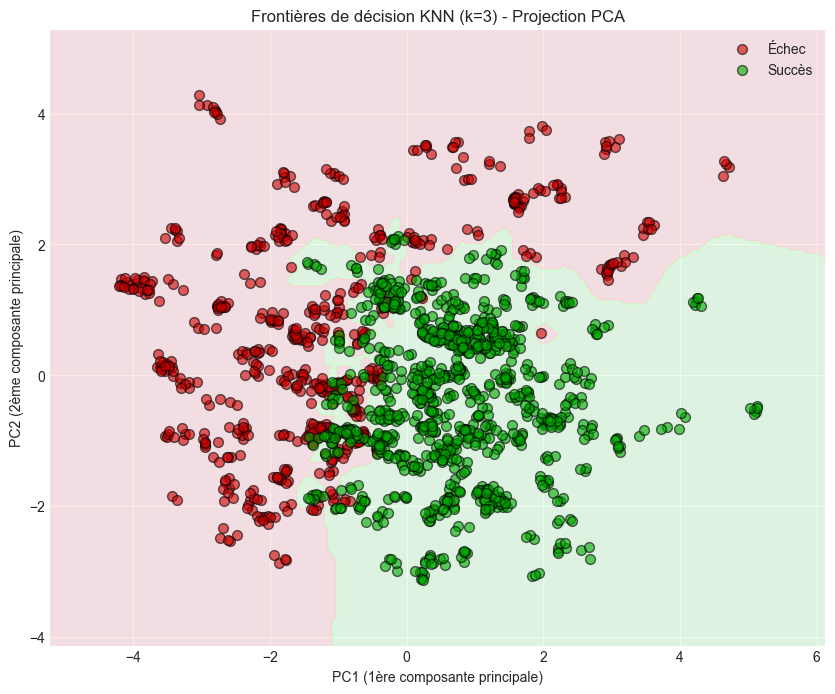

In [ ]:
from sklearn.decomposition import PCA

# Réduction à 2D avec PCA pour visualiser
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Variance expliquée par les 2 composantes: {pca.explained_variance_ratio_.sum()*100:.1f}%")

# Entraîner un KNN sur les données réduites
knn_2d = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='euclidean')
knn_2d.fit(X_train_pca, y_train)

# Créer une grille pour les frontières de décision
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Visualisation avec couleurs harmonisées (vert=succès, rouge=échec)
from matplotlib.colors import ListedColormap
colors_bg = ListedColormap(['#ffcccc', '#ccffcc'])  # Rouge clair / Vert clair pour le fond
colors_points = ['#cc0000', '#00aa00']  # Rouge / Vert pour les points

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=colors_bg)
plt.scatter(X_train_pca[y_train==0, 0], X_train_pca[y_train==0, 1], 
            c=colors_points[0], label='Échec', alpha=0.6, edgecolors='k', s=50)
plt.scatter(X_train_pca[y_train==1, 0], X_train_pca[y_train==1, 1], 
            c=colors_points[1], label='Succès', alpha=0.6, edgecolors='k', s=50)
plt.xlabel('PC1 (1ère composante principale)')
plt.ylabel('PC2 (2ème composante principale)')
plt.title('Frontières de décision KNN (k=3) - Projection PCA')
plt.legend()
plt.show()

## 8. Exploitation du modèle

Testons notre meilleur modèle avec des données de développeurs fictifs.

In [ ]:
# Création de profils de développeurs fictifs
nouveaux_devs = pd.DataFrame({
    'hours_coding': [7.5, 2.0, 5.0, 8.0, 3.5],
    'coffee_intake_mg': [550, 150, 400, 600, 200],
    'distractions': [2, 6, 3, 1, 5],
    'sleep_hours': [7.5, 5.0, 6.5, 8.0, 4.5],
    'commits': [8, 1, 4, 10, 2],
    'bugs_reported': [0, 3, 1, 0, 4],
    'ai_usage_hours': [2.0, 0.5, 1.5, 3.0, 0.2],
    'cognitive_load': [3.0, 7.5, 5.0, 2.5, 8.0]
})

profils = ['Dev Senior productif', 'Dev Junior fatigué', 'Dev Moyen', 'Dev Expert focus', 'Dev en difficulté']
nouveaux_devs.index = profils

print("Profils des développeurs à évaluer:")
nouveaux_devs

Profils des développeurs à évaluer:


,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load
Dev Senior productif,7.5,550,2,7.5,8,0,2.0,3.0
Dev Junior fatigué,2.0,150,6,5.0,1,3,0.5,7.5
Dev Moyen,5.0,400,3,6.5,4,1,1.5,5.0
Dev Expert focus,8.0,600,1,8.0,10,0,3.0,2.5
Dev en difficulté,3.5,200,5,4.5,2,4,0.2,8.0


In [ ]:
# Prédiction avec KN)
test_model = results['KNN']

# Normalisation des nouvelles données
nouveaux_devs_scaled = scaler.transform(nouveaux_devs)

# Prédictions
predictions = test_model.predict(nouveaux_devs_scaled)
probabilites = test_model.predict_proba(nouveaux_devs_scaled)[:, 1]

# Résultats
resultats = pd.DataFrame({
    'Profil': profils,
    'Prédiction': ['Succès' if p == 1 else 'Échec' for p in predictions],
    'Probabilité de succès': [f"{p*100:.1f}%" for p in probabilites]
})

print("Prédictions du modèle KNN:")
resultats

Prédictions du modèle KNN:


,Profil,Prédiction,Probabilité de succès
0,Dev Senior productif,Succès,100.0%
1,Dev Junior fatigué,Échec,0.0%
2,Dev Moyen,Succès,100.0%
3,Dev Expert focus,Succès,100.0%
4,Dev en difficulté,Échec,0.0%


In [ ]:
test_model = results['Random Forest']

# Normalisation des nouvelles données
nouveaux_devs_scaled = scaler.transform(nouveaux_devs)

# Prédictions
predictions = test_model.predict(nouveaux_devs_scaled)
probabilites = test_model.predict_proba(nouveaux_devs_scaled)[:, 1]

# Résultats
resultats = pd.DataFrame({
    'Profil': profils,
    'Prédiction': ['Succès' if p == 1 else 'Échec' for p in predictions],
    'Probabilité de succès': [f"{p*100:.1f}%" for p in probabilites]
})

print("Prédictions du modèle Random Forest:")
resultats

Prédictions du modèle Random Forest:


,Profil,Prédiction,Probabilité de succès
0,Dev Senior productif,Succès,100.0%
1,Dev Junior fatigué,Échec,1.0%
2,Dev Moyen,Succès,93.0%
3,Dev Expert focus,Succès,99.0%
4,Dev en difficulté,Échec,2.0%
